In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time

from B_data import create_residual_data, create_IC_data, initial_u,exact_u, create_BC_data, create_RH_data,create_RH_data_endt,Move_Time_1D,burgersDdt_godunov,godunov
from B_Plotting import Burgers_plot, loss_plot 
from scipy.integrate import solve_ivp

# Full PINN
from B_PINN import NN
from B_PINN_train import pinn_train

# Burgers GPT-PINN
from B_GPT_activation import P
from B_GPT_PINN import GPT
from B_GPT_train import gpt_train

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
# Training Parameter Set
number_of_parameters = 3
nu1_training = np.linspace(1.2, 1.5, 1)
nu2_training  = np.linspace(0.0, 0.1, number_of_parameters)

nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

nu_pinn_train = [1.0,0.0]
number_of_neurons = 1
P_list = np.ones(number_of_neurons, dtype=object)

In [3]:
# Domain and Data
Xi, Xf         = 0.0, 1.0
Ti, Tf         =  0.0, 1.0
Nx_train, Nt_train =  101, 201
Nx_test, Nt_test = 101, 201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

residual_data = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid      = residual_data[0].to(device)
f_hat         = residual_data[1].to(device)
xt_test       = residual_data[2].to(device)
xt_RHL      = residual_data[3].to(device)
xt_RHR      = residual_data[4].to(device)
xt_RHt         = residual_data[5].to(device)
xt_RHtL       = residual_data[6].to(device)

IC_x_test=xt_test[0:Nx_test,:1].squeeze().cpu()
IC_t_test=xt_test[0:Nx_test*Nt_test:Nx_test,1:].squeeze().cpu()

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

#xt_RH_data = create_RH_data(Xi, Xf, Ti, Tf, IC_pts, N_RH,dx)
#xt_RH = xt_RH_data[0].to(device)
#xt_RHL = xt_RH_data[1].to(device)

IC_data = create_IC_data(nu_pinn_train,Xi, Xf, Ti, Tf, IC_pts, IC_simple)
IC_xt     = IC_data[0].to(device)
IC_u      = IC_data[1].to(device)

xt_en = Move_Time_1D(IC_xt, Tf).to(device)

In [4]:
# Setting PINN and TGPT-PINN
layers_pinn = np.array([2, 30, 30, 30, 30, 30, 1])

lr_pinn     = 0.001
epochs_pinn = 30000
tol_pinn    = 1e-5

pinn_train_times = np.ones(number_of_neurons)

###############################################################################
################################ Training Loop ################################
###############################################################################

******************************************************************
Epoch: 200 | loss: 2.113879680633545,rMAE: 0.9769978239287056, rRMSE:0.9929264078160567,loss_RH:0.00000000,loss_con:0.00545834,loss_R:0.49492818117141724,loss_IC:0.09955346584320068,loss_BC:0.06234167143702507
Epoch: 400 | loss: 0.46928638219833374,rMAE: 0.9120152094948544, rRMSE:0.9394119335293124,loss_RH:0.00000000,loss_con:0.00022243,loss_R:0.4553672671318054,loss_IC:0.0007373613188974559,loss_BC:0.0006545495707541704
Epoch: 600 | loss: 0.1517610400915146,rMAE: 0.45171558716003324, rRMSE:0.5879893403394033,loss_RH:0.00000000,loss_con:0.00003605,loss_R:0.14433372020721436,loss_IC:0.0004968763096258044,loss_BC:0.0002458557428326458
Epoch: 800 | loss: 0.07088981568813324,rMAE: 0.251935403654903, rRMSE:0.36645825045330915,loss_RH:0.00000000,loss_con:0.00000473,loss_R:0.06752260774374008,loss_IC:0.00026849607820622623,loss_BC:6.822469731559977e-05
Epoch: 1000 | loss: 0.05933506414294243,rMAE: 0.20376212749831757, rRMSE:0.

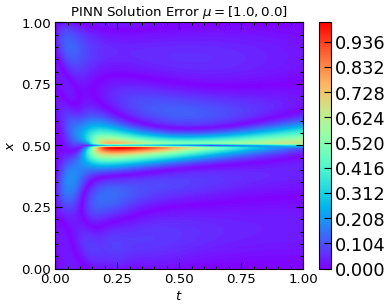

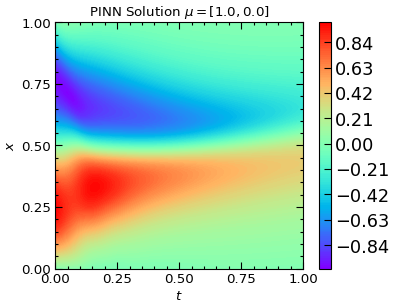

Epoch: 1200 | loss: 0.045562271028757095,rMAE: 0.17381492240367122, rRMSE:0.2784047600884853,loss_RH:0.00000000,loss_con:0.00000047,loss_R:0.04404391348361969,loss_IC:0.00011927632294828072,loss_BC:3.2559317332925275e-05
Epoch: 1400 | loss: 0.033786725252866745,rMAE: 0.14508546002729922, rRMSE:0.252336451833375,loss_RH:0.00000000,loss_con:0.00000055,loss_R:0.03264540433883667,loss_IC:8.742242061998695e-05,loss_BC:2.670950379979331e-05
Epoch: 1600 | loss: 0.028467277064919472,rMAE: 0.1274833529037695, rRMSE:0.23101689065252856,loss_RH:0.00000000,loss_con:0.00000055,loss_R:0.027624687179923058,loss_IC:5.967303513898514e-05,loss_BC:2.458595554344356e-05
Epoch: 1800 | loss: 0.025377420708537102,rMAE: 0.11531237465351898, rRMSE:0.2115440576415339,loss_RH:0.00000000,loss_con:0.00003612,loss_R:0.02428079955279827,loss_IC:4.7429002734133974e-05,loss_BC:6.223320087883621e-05
Epoch: 2000 | loss: 0.022762281820178032,rMAE: 0.10782327299515834, rRMSE:0.19638632244844276,loss_RH:0.00000000,loss_con

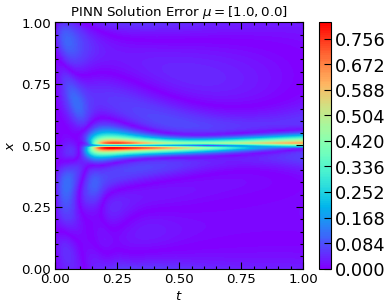

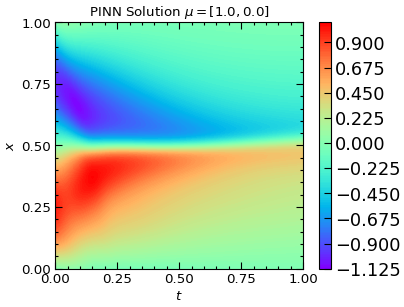

Epoch: 2200 | loss: 0.02056688815355301,rMAE: 0.09954824467672589, rRMSE:0.18209190791430188,loss_RH:0.00000000,loss_con:0.00000016,loss_R:0.020118774846196175,loss_IC:2.5751953216968104e-05,loss_BC:1.9059447367908433e-05
Epoch: 2400 | loss: 0.01877567730844021,rMAE: 0.09142006854583146, rRMSE:0.16896966493627896,loss_RH:0.00000000,loss_con:0.00001934,loss_R:0.018132606521248817,loss_IC:2.514811603759881e-05,loss_BC:3.9158920117188245e-05
Epoch: 2600 | loss: 0.016523990780115128,rMAE: 0.08370354843465455, rRMSE:0.1564765035710928,loss_RH:0.00000000,loss_con:0.00000012,loss_R:0.01617301255464554,loss_IC:1.9972356312791817e-05,loss_BC:1.5125502613955177e-05
Epoch: 2800 | loss: 0.014971291646361351,rMAE: 0.07693900118480206, rRMSE:0.14568249911645814,loss_RH:0.00000000,loss_con:0.00000001,loss_R:0.014650652185082436,loss_IC:1.8686472685658373e-05,loss_BC:1.337746925855754e-05
Epoch: 3000 | loss: 0.021132104098796844,rMAE: 0.07030522715868075, rRMSE:0.1351603539618425,loss_RH:0.00000000,lo

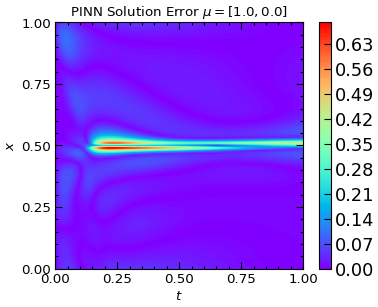

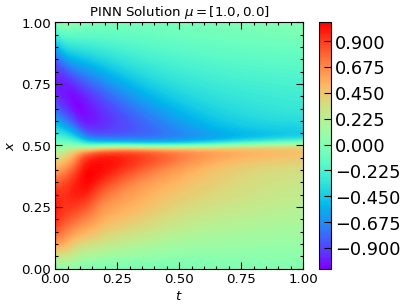

Epoch: 3200 | loss: 0.01248988602310419,rMAE: 0.06556576985138374, rRMSE:0.12608815413426622,loss_RH:0.00000000,loss_con:0.00000008,loss_R:0.012229681015014648,loss_IC:1.5820945918676443e-05,loss_BC:1.0199591088166926e-05
Epoch: 3400 | loss: 0.011623774655163288,rMAE: 0.06157401998473733, rRMSE:0.11800415384794155,loss_RH:0.00000000,loss_con:0.00000008,loss_R:0.011393197812139988,loss_IC:1.3846793081029318e-05,loss_BC:9.210901225742418e-06
Epoch: 3600 | loss: 0.010942532680928707,rMAE: 0.0577834463889571, rRMSE:0.11070870301163843,loss_RH:0.00000000,loss_con:0.00000125,loss_R:0.010721761733293533,loss_IC:1.1942408491449896e-05,loss_BC:1.0134712283615954e-05
Epoch: 3800 | loss: 0.01016240194439888,rMAE: 0.05468695827854929, rRMSE:0.10368659366179882,loss_RH:0.00000000,loss_con:0.00000008,loss_R:0.009983791038393974,loss_IC:1.0679364095267374e-05,loss_BC:7.181723958638031e-06
Epoch: 4000 | loss: 0.009618595242500305,rMAE: 0.052190096820550994, rRMSE:0.09836984343285889,loss_RH:0.00000000

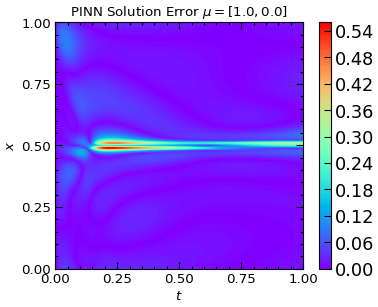

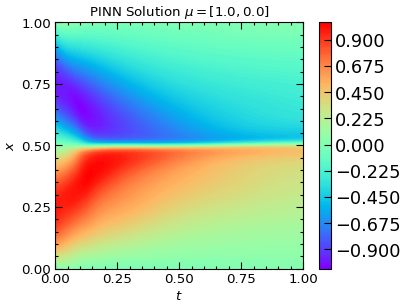

Epoch: 4200 | loss: 0.009157714433968067,rMAE: 0.05010446657470056, rRMSE:0.09396165845278436,loss_RH:0.00000000,loss_con:0.00000006,loss_R:0.009009468369185925,loss_IC:8.789666935626883e-06,loss_BC:6.034918897057651e-06
Epoch: 4400 | loss: 0.009534870274364948,rMAE: 0.047915691679609095, rRMSE:0.09030222847313576,loss_RH:0.00000000,loss_con:0.00003960,loss_R:0.008816219866275787,loss_IC:2.2516136596095748e-05,loss_BC:4.934893877361901e-05
Epoch: 4600 | loss: 0.008463525213301182,rMAE: 0.04626034697668288, rRMSE:0.08602622544895867,loss_RH:0.00000000,loss_con:0.00000006,loss_R:0.008336297236382961,loss_IC:7.886281309765764e-06,loss_BC:4.836507741856622e-06
Epoch: 4800 | loss: 0.009028811007738113,rMAE: 0.047183886354206235, rRMSE:0.09229839182384672,loss_RH:0.00000000,loss_con:0.00000006,loss_R:0.008906043134629726,loss_IC:7.681399438297376e-06,loss_BC:4.595366135617951e-06
Epoch: 5000 | loss: 0.009300456382334232,rMAE: 0.047078038580369304, rRMSE:0.09527720477717644,loss_RH:0.00000000

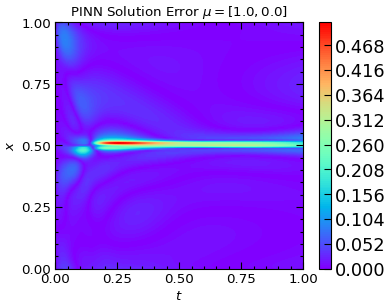

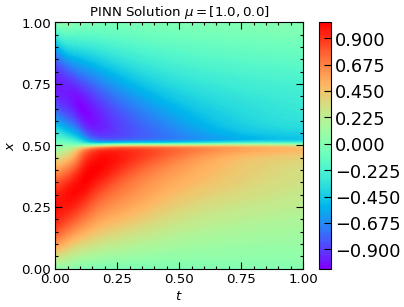

Epoch: 5200 | loss: 0.00918017141520977,rMAE: 0.04619465175059976, rRMSE:0.09564379964006932,loss_RH:0.00000000,loss_con:0.00000005,loss_R:0.009063285775482655,loss_IC:7.968533282110002e-06,loss_BC:3.720012045960175e-06
Epoch: 5400 | loss: 0.008944590575993061,rMAE: 0.0455883573104125, rRMSE:0.09581495341856296,loss_RH:0.00000000,loss_con:0.00000005,loss_R:0.00883006863296032,loss_IC:7.951937732286751e-06,loss_BC:3.5002985896426253e-06
Epoch: 5600 | loss: 0.008579003624618053,rMAE: 0.04507806207186463, rRMSE:0.09703509568130325,loss_RH:0.00000000,loss_con:0.00000002,loss_R:0.008465898223221302,loss_IC:8.02525846665958e-06,loss_BC:3.285268803665531e-06
Epoch: 5800 | loss: 0.008292077109217644,rMAE: 0.044418643919101046, rRMSE:0.09925749548599158,loss_RH:0.00000000,loss_con:0.00000058,loss_R:0.008001863956451416,loss_IC:2.3219552531372756e-05,loss_BC:5.801754923595581e-06
Epoch: 6000 | loss: 0.007374320179224014,rMAE: 0.04406590587264429, rRMSE:0.10171790231766505,loss_RH:0.00000000,loss

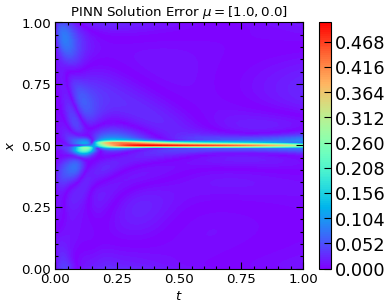

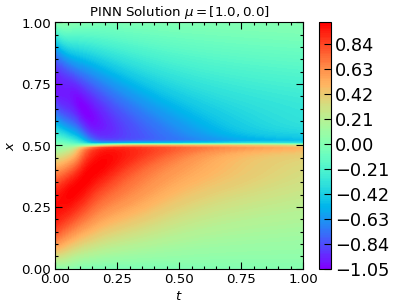

Epoch: 6200 | loss: 0.007633495144546032,rMAE: 0.04346500157923091, rRMSE:0.10399808814436584,loss_RH:0.00010152,loss_con:0.00000005,loss_R:0.006511981133371592,loss_IC:7.95443520473782e-06,loss_BC:2.6792677090270445e-06
Epoch: 6400 | loss: 0.007686817552894354,rMAE: 0.04566028856094807, rRMSE:0.10227719261607048,loss_RH:0.00016497,loss_con:0.00001377,loss_R:0.005743931047618389,loss_IC:1.2310729289310984e-05,loss_BC:1.701167093415279e-05
Epoch: 6600 | loss: 0.007228428032249212,rMAE: 0.041895441443367064, rRMSE:0.10854190463169527,loss_RH:0.00021573,loss_con:0.00000003,loss_R:0.00497325649484992,loss_IC:7.58282021706691e-06,loss_BC:2.2092374365456635e-06
Epoch: 6800 | loss: 0.006708198226988316,rMAE: 0.04110805239543464, rRMSE:0.11035719775685644,loss_RH:0.00022841,loss_con:0.00000010,loss_R:0.004327151458710432,loss_IC:7.43259079172276e-06,loss_BC:2.25725398195209e-06
Epoch: 7000 | loss: 0.007205881644040346,rMAE: 0.04112923265919329, rRMSE:0.11155235887923975,loss_RH:0.00024110,loss

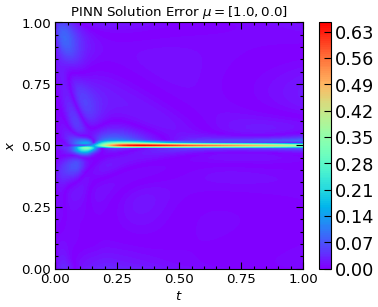

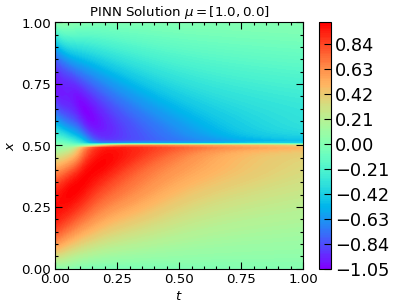

Epoch: 7200 | loss: 0.006108064204454422,rMAE: 0.039437852363901627, rRMSE:0.11321837767929421,loss_RH:0.00025379,loss_con:0.00001567,loss_R:0.003281222889199853,loss_IC:9.597361895430367e-06,loss_BC:1.929252721311059e-05
Epoch: 7400 | loss: 0.0056261480785906315,rMAE: 0.03857044932230784, rRMSE:0.11510174140546323,loss_RH:0.00026648,loss_con:0.00000002,loss_R:0.0028831232339143753,loss_IC:6.204417331900913e-06,loss_BC:1.6141202650032938e-06
Epoch: 7600 | loss: 0.005416441708803177,rMAE: 0.03783641748560125, rRMSE:0.11630031936932066,loss_RH:0.00027917,loss_con:0.00000000,loss_R:0.002552545163780451,loss_IC:5.749114734499017e-06,loss_BC:1.466927642468363e-06
Epoch: 7800 | loss: 0.0050056432373821735,rMAE: 0.03709735834039003, rRMSE:0.11741221662217252,loss_RH:0.00026648,loss_con:0.00000030,loss_R:0.002271069446578622,loss_IC:5.2845311984128784e-06,loss_BC:1.688906195340678e-06
Epoch: 8000 | loss: 0.0047607021406292915,rMAE: 0.03647007099440198, rRMSE:0.11843271168736899,loss_RH:0.00026

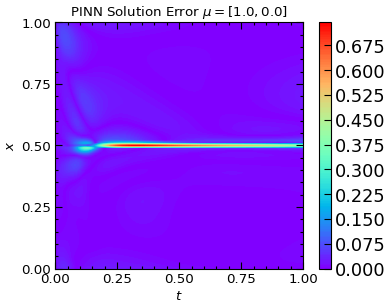

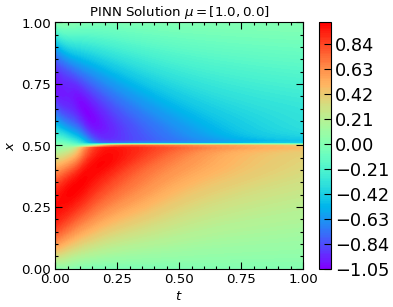

Epoch: 8200 | loss: 0.004559102468192577,rMAE: 0.03592999365475523, rRMSE:0.11933341511912554,loss_RH:0.00026648,loss_con:0.00000008,loss_R:0.0018349892925471067,loss_IC:4.62725301986211e-06,loss_BC:1.3001218803765369e-06
Epoch: 8400 | loss: 0.005348320119082928,rMAE: 0.03676584121187377, rRMSE:0.12022967070832069,loss_RH:0.00025379,loss_con:0.00000771,loss_R:0.0019299305276945233,loss_IC:7.649470353499055e-05,loss_BC:1.1550043382158037e-05
Epoch: 8600 | loss: 0.004202285315841436,rMAE: 0.03465778021906023, rRMSE:0.12083966900543208,loss_RH:0.00026648,loss_con:0.00000001,loss_R:0.0014920090325176716,loss_IC:3.601445769163547e-06,loss_BC:9.422333846487163e-07
Epoch: 8800 | loss: 0.003935881890356541,rMAE: 0.0341049615274415, rRMSE:0.1214526322376416,loss_RH:0.00025379,loss_con:0.00000000,loss_R:0.0013554181205108762,loss_IC:3.32782337864046e-06,loss_BC:9.243052545571118e-07
Epoch: 9000 | loss: 0.004288470838218927,rMAE: 0.03347307717521638, rRMSE:0.12151113476855788,loss_RH:0.00025379,l

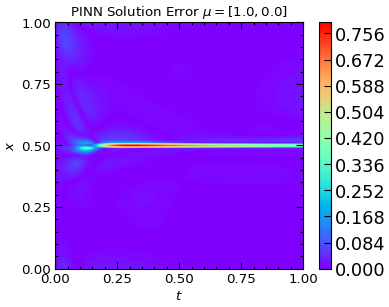

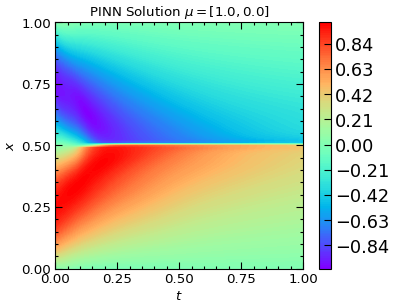

Epoch: 9200 | loss: 0.0036906437017023563,rMAE: 0.033087052745731246, rRMSE:0.12266119517466745,loss_RH:0.00025379,loss_con:0.00000000,loss_R:0.0011179856956005096,loss_IC:2.6850902941077948e-06,loss_BC:7.864858844186529e-07
Epoch: 9400 | loss: 0.004467696882784367,rMAE: 0.032263146468049723, rRMSE:0.12298323964356751,loss_RH:0.00022841,loss_con:0.00007944,loss_R:0.0010904843220487237,loss_IC:2.00327776838094e-05,loss_BC:8.927370799938217e-05
Epoch: 9600 | loss: 0.0033632349222898483,rMAE: 0.032081910945623134, rRMSE:0.12374105668007625,loss_RH:0.00024110,loss_con:0.00000010,loss_R:0.0009213998564518988,loss_IC:2.2747231014363933e-06,loss_BC:8.04262242581899e-07
Epoch: 9800 | loss: 0.003149823984131217,rMAE: 0.03163783443929357, rRMSE:0.1241858055673109,loss_RH:0.00022841,loss_con:0.00000006,loss_R:0.0008383272215723991,loss_IC:2.0547088297462324e-06,loss_BC:6.801599852224172e-07
Epoch: 10000 | loss: 0.0032074591144919395,rMAE: 0.031173864820162864, rRMSE:0.12456926230651692,loss_RH:0.

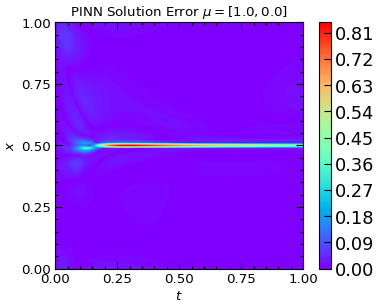

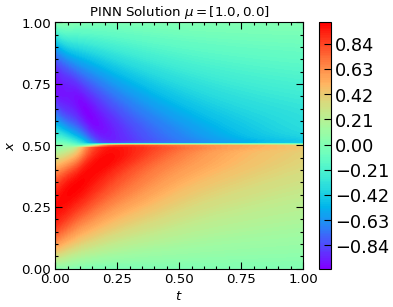

Epoch: 10200 | loss: 0.006511004641652107,rMAE: 0.040809346024325656, rRMSE:0.12863804318527097,loss_RH:0.00024110,loss_con:0.00022628,loss_R:0.0010607176227495074,loss_IC:5.404644616646692e-05,loss_BC:0.00024987771757878363
Epoch: 10400 | loss: 0.002943355357274413,rMAE: 0.030403606548882602, rRMSE:0.12547754746001785,loss_RH:0.00022841,loss_con:0.00000000,loss_R:0.0006389458430930972,loss_IC:1.518217914053821e-06,loss_BC:5.07939489580167e-07
Epoch: 10600 | loss: 0.002895368728786707,rMAE: 0.03022817703188638, rRMSE:0.1259240784654506,loss_RH:0.00022841,loss_con:0.00000004,loss_R:0.0005882768891751766,loss_IC:1.7529730484966421e-06,loss_BC:5.414070756160072e-07
Epoch: 10800 | loss: 0.004216923378407955,rMAE: 0.03076724069088865, rRMSE:0.1267499848879507,loss_RH:0.00020304,loss_con:0.00008759,loss_R:0.0008644540212117136,loss_IC:2.988167034345679e-05,loss_BC:0.00010232991189695895
Epoch: 11000 | loss: 0.0026666538324207067,rMAE: 0.029341174898594884, rRMSE:0.12659126840818216,loss_RH:0

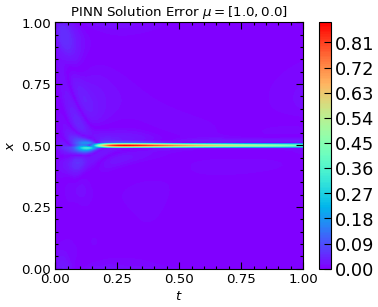

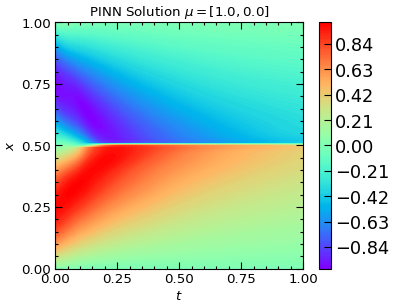

Epoch: 11200 | loss: 0.002630408853292465,rMAE: 0.02906686207315472, rRMSE:0.12688336828259786,loss_RH:0.00021573,loss_con:0.00000000,loss_R:0.0004576484498102218,loss_IC:1.1546263749551144e-06,loss_BC:3.963371284498862e-07
Epoch: 11400 | loss: 0.0025930600240826607,rMAE: 0.028781974702830698, rRMSE:0.12721432168710756,loss_RH:0.00021573,loss_con:0.00000000,loss_R:0.0004209794569760561,loss_IC:1.1139251228087232e-06,loss_BC:3.6904907574353274e-07
Epoch: 11600 | loss: 0.0024360802490264177,rMAE: 0.028501453954314745, rRMSE:0.12748991388477623,loss_RH:0.00020304,loss_con:0.00000001,loss_R:0.00039196459692902863,loss_IC:1.0106841727974825e-06,loss_BC:3.655118234746624e-07
Epoch: 11800 | loss: 0.0024125780910253525,rMAE: 0.028332751514031484, rRMSE:0.12770897887513932,loss_RH:0.00020304,loss_con:0.00000009,loss_R:0.0003674171748571098,loss_IC:1.0084976338475826e-06,loss_BC:4.722134292478586e-07
Epoch: 12000 | loss: 0.0034833718091249466,rMAE: 0.028208445861706077, rRMSE:0.12774360734576626

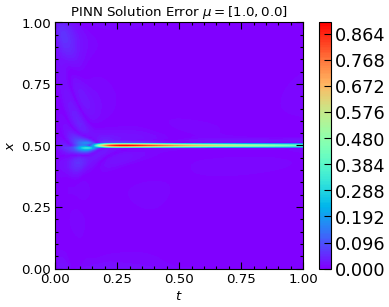

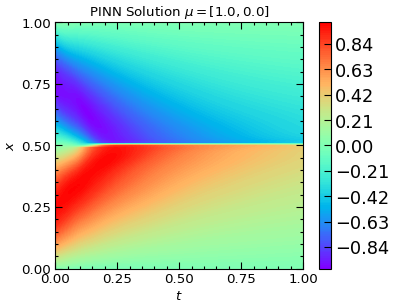

Epoch: 12200 | loss: 0.0023604431189596653,rMAE: 0.027912953372051116, rRMSE:0.12831226218702582,loss_RH:0.00020304,loss_con:0.00000007,loss_R:0.00031760919955559075,loss_IC:8.731566367714549e-07,loss_BC:3.7485372672563244e-07
Epoch: 12400 | loss: 0.0022107637487351894,rMAE: 0.02760097635327486, rRMSE:0.12851725350071666,loss_RH:0.00019035,loss_con:0.00000001,loss_R:0.00029636925319209695,loss_IC:7.88462784839794e-07,loss_BC:3.0530674166584504e-07
Epoch: 12600 | loss: 0.002192290499806404,rMAE: 0.027440981243235234, rRMSE:0.12874729390936082,loss_RH:0.00019035,loss_con:0.00000000,loss_R:0.00027853489154949784,loss_IC:7.530476295869448e-07,loss_BC:2.7684802716976264e-07
Epoch: 12800 | loss: 0.0021772142499685287,rMAE: 0.02728129510810865, rRMSE:0.12893382762177225,loss_RH:0.00019035,loss_con:0.00000000,loss_R:0.0002638470905367285,loss_IC:7.138060027500615e-07,loss_BC:2.772453626675997e-07
Epoch: 13000 | loss: 0.002169478451833129,rMAE: 0.027257240608945778, rRMSE:0.12913483466553985,lo

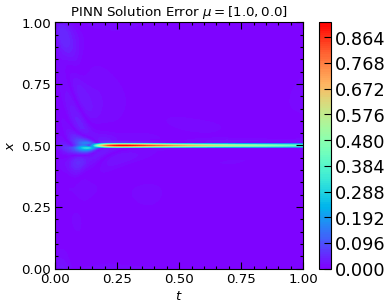

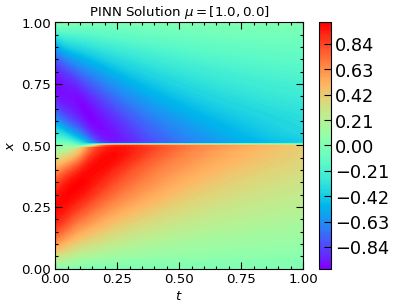

Epoch: 13200 | loss: 0.0020261749159544706,rMAE: 0.027042269766734253, rRMSE:0.12936420834339654,loss_RH:0.00017766,loss_con:0.00000002,loss_R:0.00023500024690292776,loss_IC:1.150233970292902e-06,loss_BC:3.1128772093325097e-07
Epoch: 13400 | loss: 0.002008907962590456,rMAE: 0.026803452849899437, rRMSE:0.12947071463050894,loss_RH:0.00017766,loss_con:0.00000000,loss_R:0.0002234651183243841,loss_IC:6.454681056311529e-07,loss_BC:2.428573964152747e-07
Epoch: 13600 | loss: 0.00199627922847867,rMAE: 0.026598945198939523, rRMSE:0.12960844613742456,loss_RH:0.00017766,loss_con:0.00000007,loss_R:0.00021052421652711928,loss_IC:6.044207907507371e-07,loss_BC:3.151222927044728e-07
Epoch: 13800 | loss: 0.0022400086745619774,rMAE: 0.027143425325314385, rRMSE:0.12909776642378146,loss_RH:0.00017766,loss_con:0.00000016,loss_R:0.00024621165357530117,loss_IC:2.0912450054311194e-05,loss_BC:8.113122476061108e-07
Epoch: 14000 | loss: 0.0019968408159911633,rMAE: 0.026792552050241412, rRMSE:0.12988660486436893,l

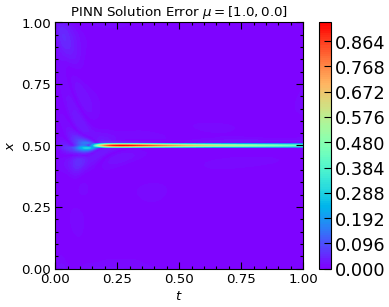

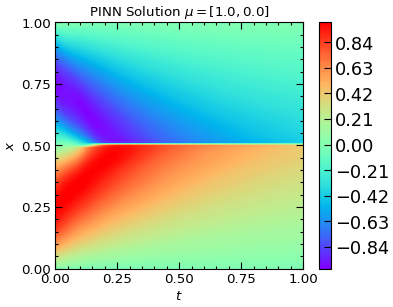

Epoch: 14200 | loss: 0.004854935687035322,rMAE: 0.031274425958337855, rRMSE:0.12971488757510868,loss_RH:0.00015228,loss_con:0.00018432,loss_R:0.0006938564474694431,loss_IC:5.452394543681294e-05,loss_BC:0.00020930742903146893
Epoch: 14400 | loss: 0.001833709655329585,rMAE: 0.026253318364623367, rRMSE:0.13013307486167724,loss_RH:0.00016497,loss_con:0.00000000,loss_R:0.00017647897766437382,loss_IC:5.539206426874443e-07,loss_BC:2.0290404734168987e-07
Epoch: 14600 | loss: 0.002215610584244132,rMAE: 0.025615783010842493, rRMSE:0.1299961920203834,loss_RH:0.00016497,loss_con:0.00002658,loss_R:0.0001929543650476262,loss_IC:7.09572577761719e-06,loss_BC:3.0203655114746653e-05
Epoch: 14800 | loss: 0.0018244043458253145,rMAE: 0.02599702676424569, rRMSE:0.13027690463263567,loss_RH:0.00016497,loss_con:0.00000003,loss_R:0.00016666838200762868,loss_IC:5.681739025931165e-07,loss_BC:2.391892337527679e-07
Epoch: 15000 | loss: 0.0018201526254415512,rMAE: 0.025994341420545894, rRMSE:0.1304365717877178,loss_

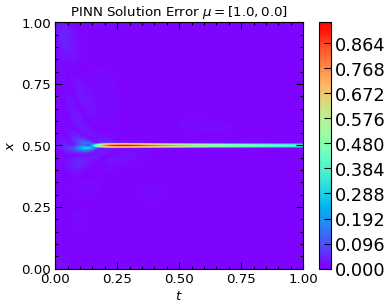

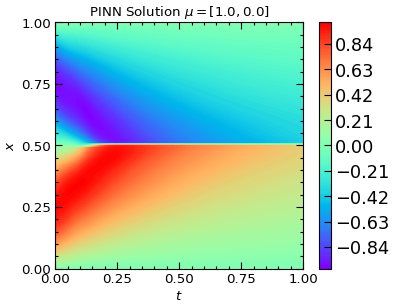

Epoch: 15200 | loss: 0.0018411889905110002,rMAE: 0.025523351771702233, rRMSE:0.13039364636656342,loss_RH:0.00016497,loss_con:0.00000236,loss_R:0.00015224538219626993,loss_IC:1.0656565336830681e-06,loss_BC:2.86246699943149e-06
Epoch: 15400 | loss: 0.001689337776042521,rMAE: 0.026101264561074772, rRMSE:0.13066377909898003,loss_RH:0.00015228,loss_con:0.00000047,loss_R:0.00015243361121974885,loss_IC:6.881009539938532e-07,loss_BC:7.257747256517177e-07
Epoch: 15600 | loss: 0.004508567973971367,rMAE: 0.031542244428317656, rRMSE:0.13131089899456275,loss_RH:0.00016497,loss_con:0.00010625,loss_R:0.00054741813801229,loss_IC:0.00010308325727237388,loss_BC:0.00012806549784727395
Epoch: 15800 | loss: 0.002044851426035166,rMAE: 0.030587181368597147, rRMSE:0.13160668582500162,loss_RH:0.00015228,loss_con:0.00002045,loss_R:0.00023970214533619583,loss_IC:5.404222520155599e-06,loss_BC:2.283416142745409e-05
Epoch: 16000 | loss: 0.010450856760144234,rMAE: 0.037774078485694335, rRMSE:0.13008805458002037,loss

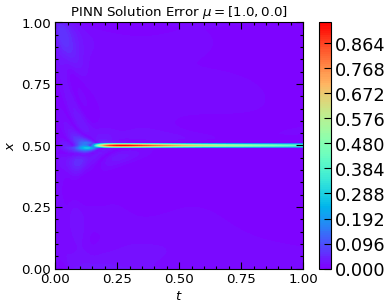

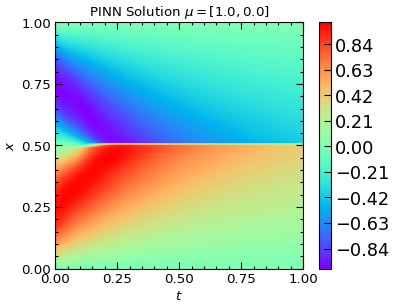

Epoch: 16200 | loss: 0.0032929019071161747,rMAE: 0.030747685913525363, rRMSE:0.1297062766946595,loss_RH:0.00013959,loss_con:0.00000463,loss_R:0.0004133793117944151,loss_IC:0.00014158662816043943,loss_BC:6.778811439289711e-06
Epoch: 16400 | loss: 0.0017400551587343216,rMAE: 0.02556455949090858, rRMSE:0.13101720217155852,loss_RH:0.00015228,loss_con:0.00000439,loss_R:0.0001476064935559407,loss_IC:1.829648795137473e-06,loss_BC:5.138682354299817e-06
Epoch: 16600 | loss: 0.0015590605325996876,rMAE: 0.0253750750435478, rRMSE:0.13096287383674257,loss_RH:0.00013959,loss_con:0.00000196,loss_R:0.0001284125610254705,loss_IC:1.06269749267085e-06,loss_BC:2.415282779111294e-06
Epoch: 16800 | loss: 0.0016658286331221461,rMAE: 0.025629390003612217, rRMSE:0.13112509222688323,loss_RH:0.00015228,loss_con:0.00000044,loss_R:0.00012935290578752756,loss_IC:6.9925880552546e-07,loss_BC:6.717772293995949e-07
Epoch: 17000 | loss: 0.001527311746031046,rMAE: 0.025537091162527583, rRMSE:0.13112753845094133,loss_RH:0

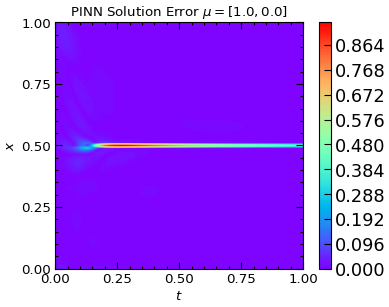

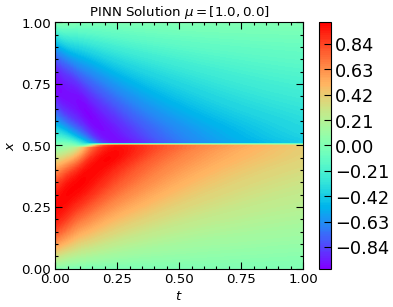

Epoch: 17200 | loss: 0.0016876872396096587,rMAE: 0.02641751650916351, rRMSE:0.13140873206886478,loss_RH:0.00015228,loss_con:0.00000147,loss_R:0.0001356970751658082,loss_IC:1.1216972097827238e-06,loss_BC:1.8007834796662792e-06
Epoch: 17400 | loss: 0.0021721720695495605,rMAE: 0.0247030597191089, rRMSE:0.1307623657690125,loss_RH:0.00013959,loss_con:0.00004151,loss_R:0.00018360857211519033,loss_IC:1.2204588529129978e-05,loss_BC:4.706494291895069e-05
Epoch: 17600 | loss: 0.001989923883229494,rMAE: 0.024547866726518916, rRMSE:0.13078422145303145,loss_RH:0.00013959,loss_con:0.00003118,loss_R:0.00013965069956611842,loss_IC:1.0138622201338876e-05,loss_BC:3.530189496814273e-05
Epoch: 17800 | loss: 0.0015143706696107984,rMAE: 0.02532260899912502, rRMSE:0.13130879440908885,loss_RH:0.00013959,loss_con:0.00000000,loss_R:0.00011163309682160616,loss_IC:5.359977990337939e-07,loss_BC:1.509473435135078e-07
Epoch: 18000 | loss: 0.0015151835978031158,rMAE: 0.025300911438442427, rRMSE:0.13130002415521883,lo

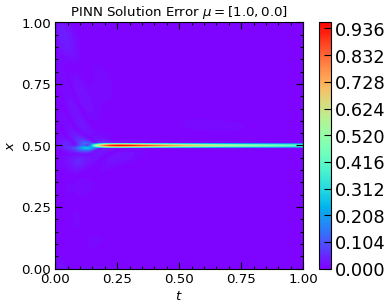

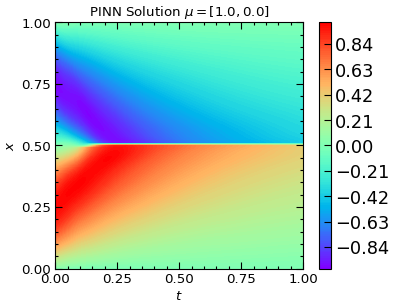

Epoch: 18200 | loss: 0.0015202666400000453,rMAE: 0.02534212630951308, rRMSE:0.1312905646266995,loss_RH:0.00013959,loss_con:0.00000000,loss_R:0.00011690795508911833,loss_IC:5.841406505169289e-07,loss_BC:1.6491367205162533e-07
Epoch: 18400 | loss: 0.0015572482952848077,rMAE: 0.026177517092723222, rRMSE:0.13162591489913186,loss_RH:0.00013959,loss_con:0.00000275,loss_R:0.00011530111805768684,loss_IC:1.3525350368581712e-06,loss_BC:3.255368710597395e-06
Epoch: 18600 | loss: 0.0015113280387595296,rMAE: 0.0252316684565589, rRMSE:0.1313941897778538,loss_RH:0.00013959,loss_con:0.00000000,loss_R:0.00010842307528946549,loss_IC:5.5619221939196e-07,loss_BC:1.4749498689070606e-07
Epoch: 18800 | loss: 0.0015243918169289827,rMAE: 0.025392833558612403, rRMSE:0.13141500609360415,loss_RH:0.00013959,loss_con:0.00000019,loss_R:0.00011803701636381447,loss_IC:6.77685648042825e-07,loss_BC:3.709869815793354e-07
Epoch: 19000 | loss: 0.0015078530414029956,rMAE: 0.025148899738614654, rRMSE:0.13144709698779358,loss

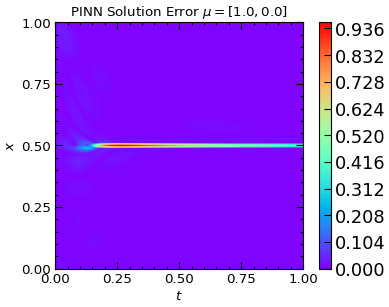

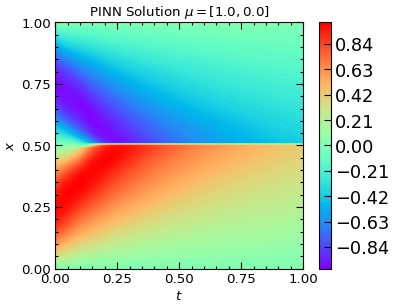

Epoch: 19200 | loss: 0.0015076177660375834,rMAE: 0.025140013224731333, rRMSE:0.13145134979295167,loss_RH:0.00013959,loss_con:0.00000000,loss_R:0.00010471065616002306,loss_IC:5.635162665384996e-07,loss_BC:1.403811040745495e-07
Epoch: 19400 | loss: 0.0015086469938978553,rMAE: 0.025137449203250936, rRMSE:0.1314399584390985,loss_RH:0.00013959,loss_con:0.00000000,loss_R:0.00010564514377620071,loss_IC:5.732175054617983e-07,loss_BC:1.4015650151577574e-07
Epoch: 19600 | loss: 0.0014110058546066284,rMAE: 0.024588007804339652, rRMSE:0.13131646052175294,loss_RH:0.00012690,loss_con:0.00000233,loss_R:0.00010241161362500861,loss_IC:1.1681711384881055e-06,loss_BC:2.7941364351136144e-06
Epoch: 19800 | loss: 0.0015144635690376163,rMAE: 0.025210628066104187, rRMSE:0.13151642274376518,loss_RH:0.00013959,loss_con:0.00000047,loss_R:0.00010483190271770582,loss_IC:6.872422773085418e-07,loss_BC:6.891054908919614e-07
Epoch: 20000 | loss: 0.002207937417551875,rMAE: 0.023677885128195353, rRMSE:0.1317470846168658

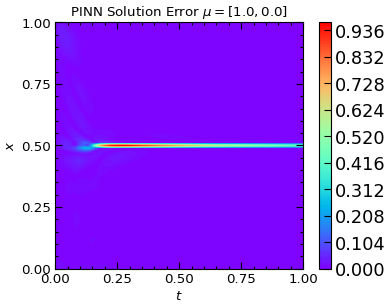

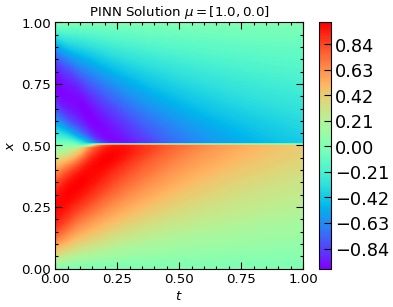

Epoch: 20200 | loss: 0.0015042806044220924,rMAE: 0.025020918837644606, rRMSE:0.13149808337732205,loss_RH:0.00013959,loss_con:0.00000000,loss_R:0.00010128274880116805,loss_IC:5.748395324189914e-07,loss_BC:1.3813554744501744e-07
Epoch: 20400 | loss: 0.0013752770610153675,rMAE: 0.024982418324955916, rRMSE:0.13151979761863627,loss_RH:0.00012690,loss_con:0.00000000,loss_R:9.927798237185925e-05,loss_IC:5.675499323842814e-07,loss_BC:1.3523971631457243e-07
Epoch: 20600 | loss: 0.0013731293147429824,rMAE: 0.02493507184681872, rRMSE:0.13155841509765312,loss_RH:0.00012690,loss_con:0.00000000,loss_R:9.71978297457099e-05,loss_IC:5.635229172185063e-07,loss_BC:1.325123974993403e-07
Epoch: 20800 | loss: 0.0013708998449146748,rMAE: 0.024879036949539978, rRMSE:0.13160186879690308,loss_RH:0.00012690,loss_con:0.00000000,loss_R:9.503165347268805e-05,loss_IC:5.596784831141122e-07,loss_BC:1.3002475895973475e-07
Epoch: 21000 | loss: 0.0013749919598922133,rMAE: 0.025432770709378716, rRMSE:0.13178207196081584,l

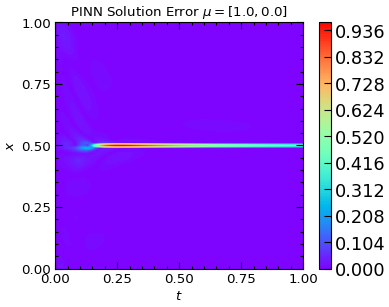

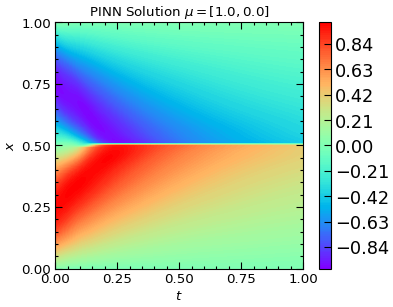

Epoch: 21200 | loss: 0.0013665977166965604,rMAE: 0.024756706235374976, rRMSE:0.131682954253399,loss_RH:0.00012690,loss_con:0.00000000,loss_R:9.08587608137168e-05,loss_IC:5.510909772965533e-07,loss_BC:1.256907893321113e-07
Epoch: 21400 | loss: 0.0013646231964230537,rMAE: 0.024700178666224013, rRMSE:0.1317205656723334,loss_RH:0.00012690,loss_con:0.00000000,loss_R:8.895745850168169e-05,loss_IC:5.463427896756912e-07,loss_BC:1.2311674879583734e-07
Epoch: 21600 | loss: 0.0013628046726807952,rMAE: 0.02463963964593716, rRMSE:0.1317542916705293,loss_RH:0.00012690,loss_con:0.00000000,loss_R:8.720774349058047e-05,loss_IC:5.418932573775237e-07,loss_BC:1.2068335308867972e-07
Epoch: 21800 | loss: 0.0013887250097468495,rMAE: 0.023990335812437955, rRMSE:0.13163675900441144,loss_RH:0.00012690,loss_con:0.00000190,loss_R:8.675332355778664e-05,loss_IC:1.0023780987467035e-06,loss_BC:2.2976753371040104e-06
Epoch: 22000 | loss: 0.0013691890053451061,rMAE: 0.02413791985648539, rRMSE:0.13172291282459353,loss_R

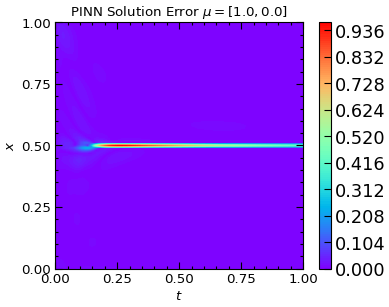

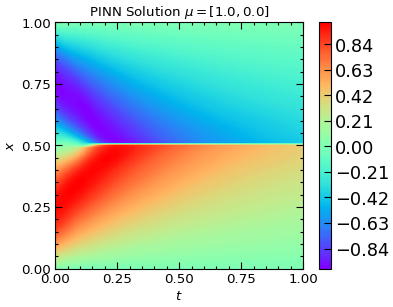

Epoch: 22200 | loss: 0.0013576219789683819,rMAE: 0.02448905659705688, rRMSE:0.13184718194409184,loss_RH:0.00012690,loss_con:0.00000000,loss_R:8.22659203549847e-05,loss_IC:5.223699872658472e-07,loss_BC:1.1612802808258493e-07
Epoch: 22400 | loss: 0.0013560708612203598,rMAE: 0.02444554593176201, rRMSE:0.1318737650852969,loss_RH:0.00012690,loss_con:0.00000000,loss_R:8.080523548414931e-05,loss_IC:5.155009716872883e-07,loss_BC:1.1395069776654054e-07
Epoch: 22600 | loss: 0.001354589476250112,rMAE: 0.024402227839835634, rRMSE:0.13189734804890718,loss_RH:0.00012690,loss_con:0.00000000,loss_R:7.941285002743825e-05,loss_IC:5.084345957584446e-07,loss_BC:1.1211361083951488e-07
Epoch: 22800 | loss: 0.0013533404562622309,rMAE: 0.024348043042858713, rRMSE:0.1319162502459492,loss_RH:0.00012690,loss_con:0.00000000,loss_R:7.818768790457398e-05,loss_IC:5.04658942190872e-07,loss_BC:1.1350540063403969e-07
Epoch: 23000 | loss: 0.0013518192572519183,rMAE: 0.024322144703551297, rRMSE:0.13193866469961463,loss_R

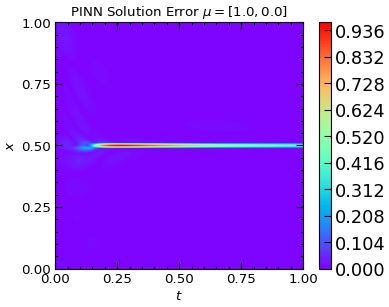

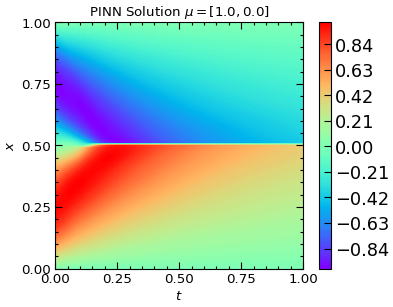

Epoch: 23200 | loss: 0.0013504665112122893,rMAE: 0.024272136689140685, rRMSE:0.13195406613656288,loss_RH:0.00012690,loss_con:0.00000000,loss_R:7.555522461188957e-05,loss_IC:4.865523237640446e-07,loss_BC:1.0746365575187156e-07
Epoch: 23400 | loss: 0.0013491730205714703,rMAE: 0.024178031334097246, rRMSE:0.13195766777448054,loss_RH:0.00012690,loss_con:0.00000000,loss_R:7.433472637785599e-05,loss_IC:4.793649281964463e-07,loss_BC:1.0734831334957562e-07
Epoch: 23600 | loss: 0.0013479071203619242,rMAE: 0.024204938845327754, rRMSE:0.13198659559675555,loss_RH:0.00012690,loss_con:0.00000000,loss_R:7.318737334571779e-05,loss_IC:4.721148343378445e-07,loss_BC:1.0275125106318228e-07
Epoch: 23800 | loss: 0.0013466904638335109,rMAE: 0.024167484536183243, rRMSE:0.13199857481052782,loss_RH:0.00012690,loss_con:0.00000000,loss_R:7.205978181445971e-05,loss_IC:4.6497001449097297e-07,loss_BC:1.0098418812276577e-07
Epoch: 24000 | loss: 0.0013454962754622102,rMAE: 0.024125930168318294, rRMSE:0.1320081442455413

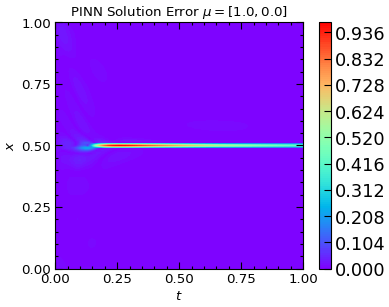

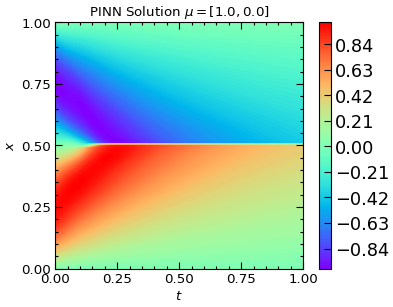

Epoch: 24200 | loss: 0.00134840898681432,rMAE: 0.02394652566180332, rRMSE:0.13198986604005902,loss_RH:0.00012690,loss_con:0.00000029,loss_R:6.989421672187746e-05,loss_IC:5.204271360526036e-07,loss_BC:4.3393254145485116e-07
Epoch: 24400 | loss: 0.001343251671642065,rMAE: 0.024068826535106103, rRMSE:0.13203067255309278,loss_RH:0.00012690,loss_con:0.00000000,loss_R:6.887601921334863e-05,loss_IC:4.4499887508209213e-07,loss_BC:9.544871915068143e-08
Epoch: 24600 | loss: 0.0013422195333987474,rMAE: 0.024036107032267495, rRMSE:0.13204017366455723,loss_RH:0.00012690,loss_con:0.00000000,loss_R:6.790612678742036e-05,loss_IC:4.4003218135912903e-07,loss_BC:9.419312618774711e-08
Epoch: 24800 | loss: 0.001341213588602841,rMAE: 0.023990702967909443, rRMSE:0.13204454337534682,loss_RH:0.00012690,loss_con:0.00000001,loss_R:6.691653106827289e-05,loss_IC:4.3304447672198876e-07,loss_BC:9.954622726127127e-08
Epoch: 25000 | loss: 0.0013414636487141252,rMAE: 0.0240982885078634, rRMSE:0.13207861758940273,loss_R

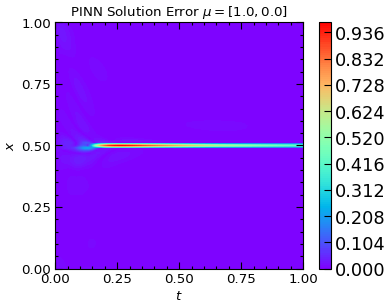

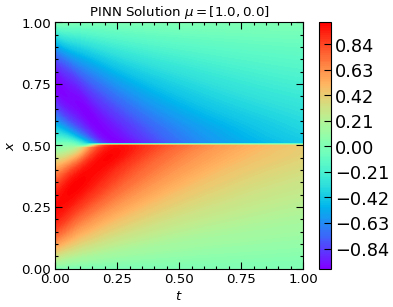

Epoch: 25200 | loss: 0.0013408014783635736,rMAE: 0.023784033754176457, rRMSE:0.13201841231820952,loss_RH:0.00012690,loss_con:0.00000012,loss_R:6.507345096906647e-05,loss_IC:4.4729605974680453e-07,loss_BC:2.2839057578494248e-07
Epoch: 25400 | loss: 0.0013383700279518962,rMAE: 0.023904366752277077, rRMSE:0.1320679763360701,loss_RH:0.00012690,loss_con:0.00000000,loss_R:6.433822272811085e-05,loss_IC:4.1671273720567115e-07,loss_BC:8.935821682598544e-08
Epoch: 25600 | loss: 0.001337738591246307,rMAE: 0.023893575817995033, rRMSE:0.13207616413145007,loss_RH:0.00012690,loss_con:0.00000001,loss_R:6.358810787787661e-05,loss_IC:4.161526305779262e-07,loss_BC:1.0177856779591821e-07
Epoch: 25800 | loss: 0.0013391240499913692,rMAE: 0.02380474079342405, rRMSE:0.13209566751867105,loss_RH:0.00012690,loss_con:0.00000017,loss_R:6.2633836932946e-05,loss_IC:4.6520978003172786e-07,loss_BC:2.867022885766346e-07
Epoch: 26000 | loss: 0.0013437101151794195,rMAE: 0.024229395916576, rRMSE:0.13215764201809768,loss_R

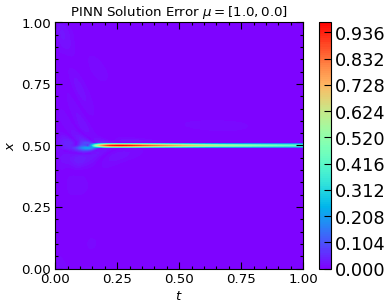

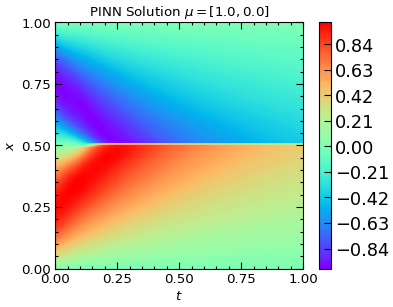

Epoch: 26200 | loss: 0.0013516591861844063,rMAE: 0.024495048149724856, rRMSE:0.13221597733973284,loss_RH:0.00012690,loss_con:0.00000101,loss_R:6.343379936879501e-05,loss_IC:6.984476499383163e-07,loss_BC:1.2269766784811509e-06
Epoch: 26400 | loss: 0.0013376843417063355,rMAE: 0.02389413991081413, rRMSE:0.13215117425970163,loss_RH:0.00012690,loss_con:0.00000004,loss_R:6.090927854529582e-05,loss_IC:6.565342118847184e-07,loss_BC:1.238566085248749e-07
Epoch: 26600 | loss: 0.0013392552500590682,rMAE: 0.024075815536323906, rRMSE:0.1321539564225464,loss_RH:0.00012690,loss_con:0.00000035,loss_R:6.062527245376259e-05,loss_IC:4.903376407128235e-07,loss_BC:4.7555101900798036e-07
Epoch: 26800 | loss: 0.0013326348271220922,rMAE: 0.023639481562854267, rRMSE:0.1320895053546434,loss_RH:0.00012690,loss_con:0.00000002,loss_R:5.8815399825107306e-05,loss_IC:3.844885725357017e-07,loss_BC:1.0033740238668543e-07
Epoch: 27000 | loss: 0.0015069100772961974,rMAE: 0.022468719670478705, rRMSE:0.1318376181534841,los

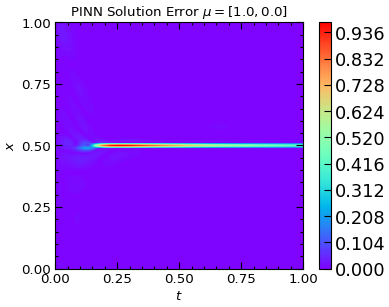

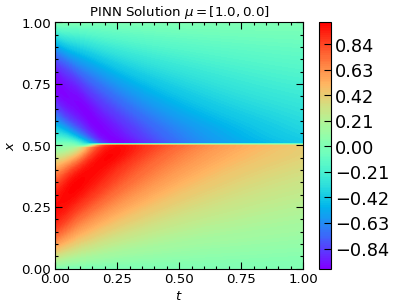

Epoch: 27200 | loss: 0.0013335251715034246,rMAE: 0.023760105114206537, rRMSE:0.13206426948450406,loss_RH:0.00012690,loss_con:0.00000003,loss_R:5.80978266953025e-05,loss_IC:5.275784928926441e-07,loss_BC:1.1804755928324084e-07
Epoch: 27400 | loss: 0.0013302253792062402,rMAE: 0.023636396251841645, rRMSE:0.13210487626162118,loss_RH:0.00012690,loss_con:0.00000000,loss_R:5.678731031366624e-05,loss_IC:3.653632916211791e-07,loss_BC:8.133400086762776e-08
Epoch: 27600 | loss: 0.0013416442088782787,rMAE: 0.02355043729103158, rRMSE:0.13208271385965217,loss_RH:0.00012690,loss_con:0.00000081,loss_R:5.671279359376058e-05,loss_IC:5.876645445823669e-07,loss_BC:1.008362687571207e-06
Epoch: 27800 | loss: 0.0013288789195939898,rMAE: 0.023878546137036313, rRMSE:0.1321652248533547,loss_RH:0.00012690,loss_con:0.00000000,loss_R:5.556929318117909e-05,loss_IC:3.576304550279019e-07,loss_BC:7.622237774285168e-08
Epoch: 28000 | loss: 0.0013281372375786304,rMAE: 0.02360049739907321, rRMSE:0.13211626354941833,loss_R

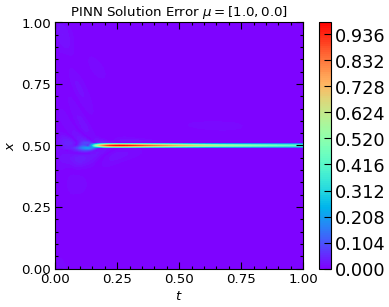

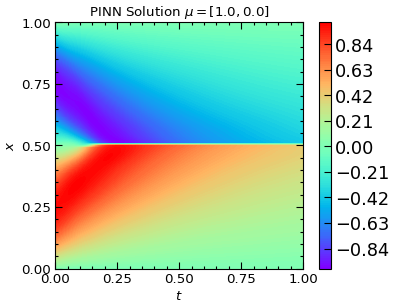

Epoch: 28200 | loss: 0.001327509293332696,rMAE: 0.023579882855236284, rRMSE:0.13211653173414573,loss_RH:0.00012690,loss_con:0.00000000,loss_R:5.4333198931999505e-05,loss_IC:3.4789451319738873e-07,loss_BC:7.260564416355919e-08
Epoch: 28400 | loss: 0.0013268900802358985,rMAE: 0.02349810820841229, rRMSE:0.13211090079187832,loss_RH:0.00012690,loss_con:0.00000000,loss_R:5.369579594116658e-05,loss_IC:3.44841538435503e-07,loss_BC:7.747520669454389e-08
Epoch: 28600 | loss: 0.0013361541787162423,rMAE: 0.023069342251084732, rRMSE:0.13202915831016446,loss_RH:0.00012690,loss_con:0.00000067,loss_R:5.3644063882529736e-05,loss_IC:5.228170607551874e-07,loss_BC:8.310774433084589e-07
Epoch: 28800 | loss: 0.0013263985747471452,rMAE: 0.023530826406739567, rRMSE:0.13210985935719757,loss_RH:0.00012690,loss_con:0.00000002,loss_R:5.280542609398253e-05,loss_IC:3.7043866996100405e-07,loss_BC:9.176162052426662e-08
Epoch: 29000 | loss: 0.001325008226558566,rMAE: 0.02350288028251599, rRMSE:0.13212329919143337,loss

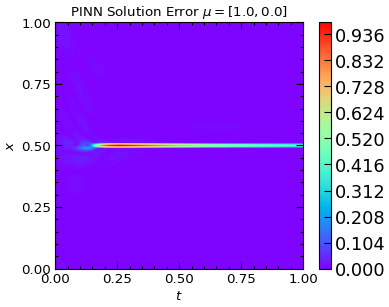

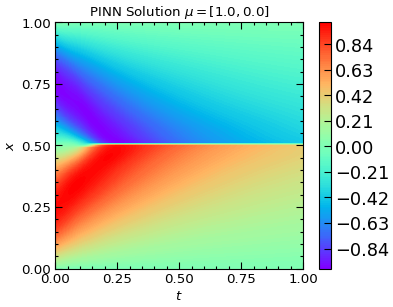

Epoch: 29200 | loss: 0.0013244125293567777,rMAE: 0.023482676187766224, rRMSE:0.13212401178979782,loss_RH:0.00012690,loss_con:0.00000000,loss_R:5.147761112311855e-05,loss_IC:3.2831172802616493e-07,loss_BC:6.806510555179557e-08
Epoch: 29400 | loss: 0.0013238394167274237,rMAE: 0.023462648860794664, rRMSE:0.13212501378189917,loss_RH:0.00012690,loss_con:0.00000000,loss_R:5.094895823276602e-05,loss_IC:3.2472527777827054e-07,loss_BC:6.720716072550204e-08
Epoch: 29600 | loss: 0.0013232886558398604,rMAE: 0.02345119182804092, rRMSE:0.1321268837235606,loss_RH:0.00012690,loss_con:0.00000000,loss_R:5.04433992318809e-05,loss_IC:3.212772128335928e-07,loss_BC:6.613788627873873e-08
Epoch: 29800 | loss: 0.0013227517483755946,rMAE: 0.023429514002070967, rRMSE:0.1321295377722848,loss_RH:0.00012690,loss_con:0.00000000,loss_R:4.992475805920549e-05,loss_IC:3.1943832823344565e-07,loss_BC:6.615272951648876e-08
Epoch: 30000 | loss: 0.001322489115409553,rMAE: 0.02333370581795809, rRMSE:0.13212164187401917,loss_R

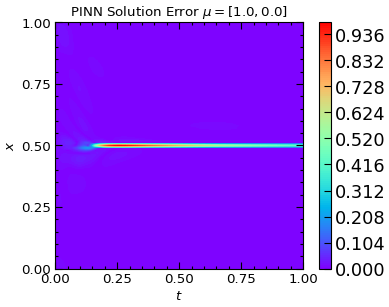

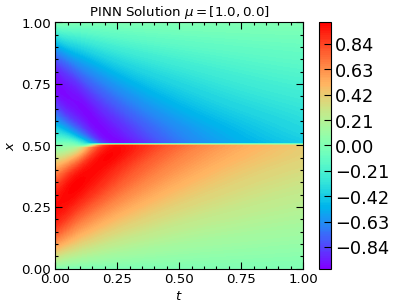

PINN Training Completed

PINN Training Time: 0.11455365901657691 Hours


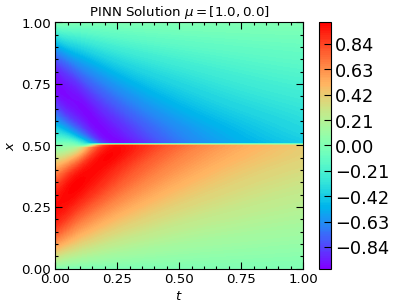

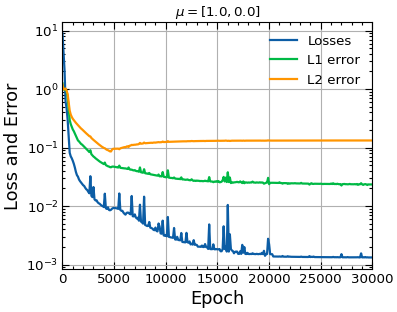

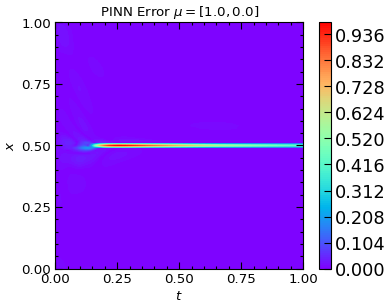

PINN at [1.0, 0.0] with the rMAE = 0.02333370581795809 and rRMSE = 0.13212164187401917


In [5]:
total_train_time_1 = time.perf_counter()
for i in range(0, number_of_neurons):
    print("******************************************************************")
    ########################### Full PINN Training ###########################
    IC_data = create_IC_data(nu_pinn_train,Xi, Xf, Ti, Tf, IC_pts, IC_simple)
    IC_xt     = IC_data[0].to(device)
    IC_u      = IC_data[1].to(device)
    #plt.scatter(IC_xt[:,1].detach().cpu(),IC_xt[:,0].detach().cpu(),s=0.1)

    IC_u_test = initial_u(nu_pinn_train,IC_x_test)
    God_sol=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test.cpu(), t_eval=IC_t_test)
    Exact_y = torch.from_numpy(God_sol.y.T.reshape(xt_test.shape[0],1)).to(device)
    #Burgers_plot(xt_test, Exact_y, Nx_test,Nt_test, title=fr"Exact Solution $\mu={round(nu_pinn_train,3)}$")

    pinn_train_time_1 = time.perf_counter()
    PINN = NN(nu_pinn_train, layers_pinn,dt).to(device)
        
    pinn_losses = pinn_train(PINN, nu_pinn_train, xt_resid, IC_xt, IC_u, BC1, BC2,xt_RHL, xt_RHR,xt_RHt,xt_RHtL, f_hat, Exact_y, epochs_pinn, lr_pinn, tol_pinn, xt_test)

    pinn_train_time_2 = time.perf_counter()
    print(f"PINN Training Time: {(pinn_train_time_2-pinn_train_time_1)/3600} Hours")

    Burgers_plot(xt_test, PINN(xt_test),Nx_test,Nt_test, title=fr"PINN Solution $\mu={nu_pinn_train}$")
        
    plt.figure(dpi=80, figsize=(5,4))    
    plt.plot(pinn_losses[0], pinn_losses[1], linewidth=2, label="Losses")
    plt.plot(pinn_losses[0], pinn_losses[2], linewidth=2, label="L1 error")
    plt.plot(pinn_losses[0], pinn_losses[3], linewidth=2, label="L2 error")
    
    plt.xlabel("Epoch",     fontsize=16)
    plt.ylabel("Loss and Error", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
     
    plt.grid(True)
    plt.xlim(0,max(pinn_losses[0]))
    plt.yscale('log')
    plt.title(fr"$\mu={nu_pinn_train}$",fontsize=12)
    plt.legend(fontsize = 12)#
    plt.show()

    # Compute Full PINN Error
    rMAE = max(sum(abs(PINN(xt_test)-Exact_y))/sum(abs(Exact_y)))
    rRMSE = torch.sqrt(sum((PINN(xt_test)-Exact_y)**2)/sum((Exact_y)**2)).item()
    Burgers_plot(xt_test, abs(PINN(xt_test)-Exact_y), Nx_test,Nt_test,title=fr"PINN Error $\mu={nu_pinn_train}$")
    print(f"PINN at {nu_pinn_train} with the rMAE = {rMAE} and rRMSE = {rRMSE}")
total_train_time_2 = time.perf_counter()            

In [6]:
w1 = PINN.linears[0].weight.detach().cpu()
w2 = PINN.linears[1].weight.detach().cpu()
w3 = PINN.linears[2].weight.detach().cpu()
w4 = PINN.linears[3].weight.detach().cpu()
w5 = PINN.linears[4].weight.detach().cpu()
w6 = PINN.linears[5].weight.detach().cpu()

b1 = PINN.linears[0].bias.detach().cpu()
b2 = PINN.linears[1].bias.detach().cpu()
b3 = PINN.linears[2].bias.detach().cpu()
b4 = PINN.linears[3].bias.detach().cpu()
b5 = PINN.linears[4].bias.detach().cpu()
b6 = PINN.linears[5].bias.detach().cpu()

# Add new activation functions
P_list[i] = P(layers_pinn, w1, w2, w3, w4, w5,w6, b1, b2, b3, b4,b5,b6).to(device)

import pickle 
with open('IFNN_shock3_0521.pkl', 'wb') as f:
        pickle.dump(P_list, f)

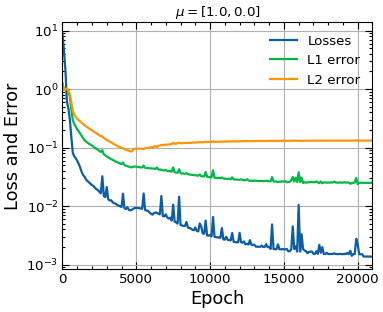

In [7]:
plt.figure(dpi=80, figsize=(5,4))    
plt.plot(pinn_losses[0], pinn_losses[1], linewidth=2, label="Losses")
plt.plot(pinn_losses[0], pinn_losses[2], linewidth=2, label="L1 error")
plt.plot(pinn_losses[0], pinn_losses[3], linewidth=2, label="L2 error")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss and Error", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
plt.xlim(0,21000)
plt.yscale('log')
plt.title(fr"$\mu={nu_pinn_train}$",fontsize=12)
plt.legend(fontsize = 12)#
plt.show()

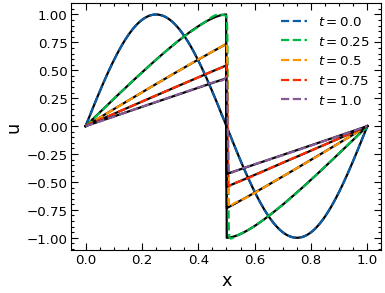

In [10]:
Nx_test, Nt_test = 1001, 2001
xt_test = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)[2].to(device)
IC_x_test=xt_test[0:Nx_test,:1].squeeze().cpu()
IC_u_test = initial_u(nu_pinn_train,IC_x_test)
IC_t_test = xt_test[0:Nx_test*Nt_test:Nx_test,1:].squeeze().cpu()
God_sol=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test.cpu(), t_eval=IC_t_test)
Exact_y = torch.from_numpy(God_sol.y.T.reshape(xt_test.shape[0],1)).to(device)

plt.figure(dpi=80, figsize=(5,4))#dpi=150, figsize=(10,8)
for ind in range(1, Nt_test+1,500):
    plt.plot(xt_test[0:Nx_test,0].detach().cpu(),Exact_y[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.plot(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
plt.xlabel("x",     fontsize=16)
plt.ylabel("u", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()